In [427]:
from imm import imm
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


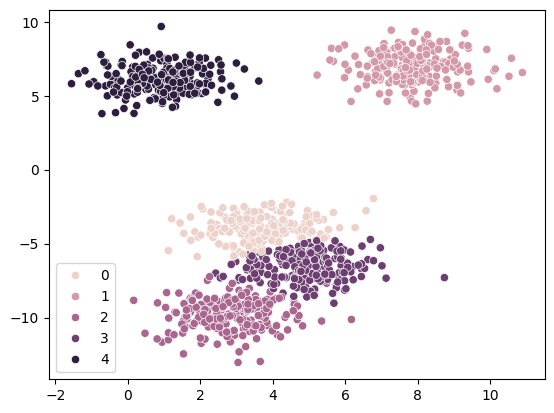

In [428]:
dims = 2
n = 1000
k = 5

X, y_ = make_blobs(centers=k, cluster_std=1,n_features=dims, n_samples=n)
model = KMeans(n_clusters=k)
model.fit(X)
centers = model.cluster_centers_
y = model.predict(X)
# pca = PCA(n_components=2)
# embed_X = pca.fit_transform(X)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

#initialize with 2 clusters
# X = np.array([[1, 2], [1, 4], [1, 0],
#               [10, 2], [10, 4], [10, 0]])

imm_model = imm()
imm_model.fit(X, y, centers)

In [429]:
print(imm_model.write_tree())

├── L0: 1 < -1.4203633913264158
│   ├── L1: 1 < -6.884171165815322
│   │   ├── L2, C: 2
│   │   └── L2: 1 < -5.24290739861101
│   │       ├── L3, C: 3
│   │       └── L3, C: 0
│   └── L1: 0 < 4.365992261511698
│       ├── L2, C: 4
│       └── L2, C: 1



In [430]:
instance_index = y.argmin()
instance = X[instance_index]
target_class = 2
target_point = centers[target_class, :]
print(f"Instance class: {y[instance_index]}, point: {instance}")
print(f"Target center class: {target_class}, point {target_point}\n")

instance_path = imm_model.get_path(instance)
target_path = imm_model.get_path(target_point)
print(f"Instance path: {instance_path}")
print(f"Target path: {target_path}\n")

path_len = min(len(instance_path), len(target_path))
path_equality = instance_path[:path_len] == target_path[:path_len]
last_equal_parent = np.nonzero(path_equality)[0].max()
print("Index in tree of parent equality: ", last_equal_parent)
path_of_changes = target_path[last_equal_parent:]
print("Path of changes: ", path_of_changes)

cf = instance.copy()

for i in range(len(path_of_changes) - 1):
    print(f"Change {i}:")
    curr_node = path_of_changes[i]
    if curr_node.left == path_of_changes[i+1]:
        if cf[curr_node.feature] >= curr_node.threshold:
            cf[curr_node.feature] = curr_node.threshold - 0.0001
    else:
        if cf[curr_node.feature] < curr_node.threshold:
            cf[curr_node.feature] = curr_node.threshold

print("Counterfactual: ", cf)

Instance class: 0, point: [ 4.32347107 -3.66907315]
Target center class: 2, point [ 2.8295975  -9.82753347]

Instance path: [<imm.Node object at 0x7321b0867af0> <imm.Node object at 0x7321b0867b50>
 <imm.Node object at 0x7321b0824490> <imm.Node object at 0x7321b0826800>]
Target path: [<imm.Node object at 0x7321b0867af0> <imm.Node object at 0x7321b0867b50>

Index in tree of parent equality:  1
Path of changes:  [<imm.Node object at 0x7321b0867b50> <imm.Node object at 0x7321b0824d00>]
Change 0:
Counterfactual:  [ 4.32347107 -6.88427117]


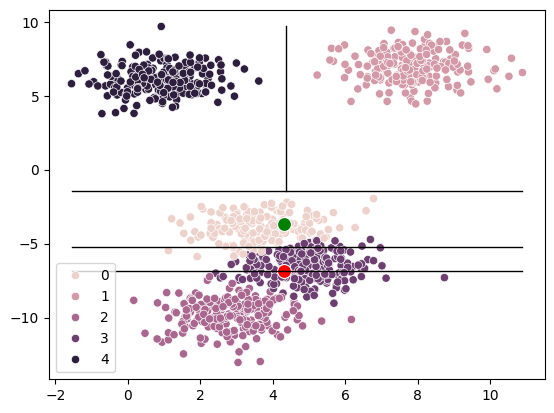

In [431]:
def plot_decision_boundaries(node, x_min, x_max, y_min, y_max, depth=0):
    if node is None or node.cluster is not None:
        return
    
    if node.feature == 0:
        plt.plot([node.threshold, node.threshold], [y_min, y_max], 'k-', lw=1)
        plot_decision_boundaries(node.left, x_min, node.threshold, y_min, y_max, depth + 1)
        plot_decision_boundaries(node.right, node.threshold, x_max, y_min, y_max, depth + 1)
    elif node.feature == 1:
        plt.plot([x_min, x_max], [node.threshold, node.threshold], 'k-', lw=1)
        plot_decision_boundaries(node.left, x_min, x_max, y_min, node.threshold, depth + 1)
        plot_decision_boundaries(node.right, x_min, x_max, node.threshold, y_max, depth + 1)

# Assuming imm_model is an instance of the imm class and has been fitted
tree = imm_model.tree

# Plot the data points
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
sns.scatterplot(x=[cf[0]], y=[cf[1]], color='red', s=100)
sns.scatterplot(x=[instance[0]], y=[instance[1]], color='green', s=100)

# Plot the decision boundaries
plot_decision_boundaries(tree, X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max())

plt.show()